# QPAD result visualization

In [2]:
import json
from collections import OrderedDict
from importlib import reload
import helper
helper = reload(helper)
from helper import *
import numpy as np
import matplotlib.pyplot as plt
import pyVisQP
dirname = '..'

## Raw beam data analysis

In [3]:
# Only the particles within the range of:
# [zVisualizeCenter - half_thickness, zVisualizeCenter + half_thickness]
# will be considered as a part of the beam and participate in the analysis.
# If the beam profile is not described by sigma_z (longitudinal piecewise linear),
# then all the particles in the beam will be analyzed.
half_thickness = 5
zVisualizeCenter = 0

# The following is the default setting to analyze raw beam data for all output files
QPAD = True
ndump = get_one_item(['beam',0,'diag',-1,'ndump'])
time = get_one_item(['simulation','time'])
dt = get_one_item(['simulation','dt'])
nbeams = get_one_item(['simulation','nbeams'])
first_file_number = 0
last_file_number = int(time // ( dt * ndump) * ndump )
beam_number = nbeams # Usually, the witness beam is the last beam in the input file

In [3]:
pyVisQP = reload(pyVisQP)
# You cannot have any comment in qpinput.json !!!
parameters = pyVisQP.analyze_raw_beam_data(first_file_number = first_file_number,\
                                           last_file_number = last_file_number,\
                                           ndump = ndump,beam_number = beam_number, \
                                           zVisualizeCenter = zVisualizeCenter, \
                                           half_thickness = half_thickness, \
                                           QPAD = QPAD)
pyVisQP.save_beam_analysis(beam_number,[zVisualizeCenter],[parameters],half_thickness)

In file ../Beam1/Raw/raw_00000000.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00000200.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00000400.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00000600.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00000800.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00001000.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00001200.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00001400.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00001600.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00001800.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00002000.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00002200.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00002400.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00002600.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_00002800.h5, analyzing 100.0% particles
In file ../Beam1/Raw/raw_

## Visualize the raw beam data

In [4]:
filename = 'beam' + str(beam_number) + '_' + str([zVisualizeCenter]).replace(" ","") + '_' + str(half_thickness)
with open(filename) as f:
    parameters = json.load(f,object_pairs_hook=OrderedDict)
parameters = parameters[str(zVisualizeCenter)]

## Plasma ramp data

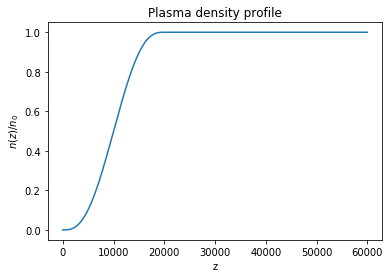

In [6]:
s, fs = get_density_profile(name = 'species', idx=0, plot=True, save=True, path = '..')
matched_parameters = get_matched_beam_parameters(i = 0,name = 'species',idx = 0,path = '..')
delta_s = parameters['s'][1] - parameters['s'][0]
delta_s_matched = matched_parameters['s'][1] - matched_parameters['s'][0]
alpha_i = get_one_item(['beam',0,'alpha',0])
beta_i = get_one_item(['beam',0,'beta',0])
s = np.array(parameters['s'])
alpha_vacuum,beta_vacuum = get_Twiss_in_vacuum(alpha_i,beta_i,s)

# $$\epsilon_n$$

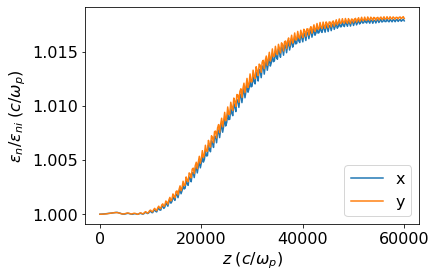

In [6]:
pyVisQP = reload(pyVisQP)

# fig, ax = plt.subplots()
plt.plot(parameters['s'], parameters['epsilon_n_x']/np.float64(parameters['epsilon_n_x'][0]),label='x')
plt.plot(parameters['s'], parameters['epsilon_n_y']/np.float64(parameters['epsilon_n_y'][0]),label='y')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel('$\epsilon_n / \epsilon_{ni}  \;(c/\omega_p)$')

plt.legend(loc='lower right')
plt.rcParams.update({'font.size': 16})
plt.savefig('beam'+str(beam_number)+'_emitn'+'.png')
plt.show()

# $$\beta$$

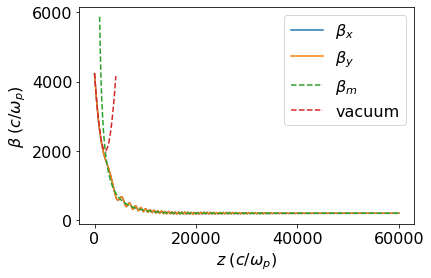

In [8]:
plot_beta_m = True
plot_beta_vacuum = True

s_cutoff = parameters['s'][-1] # only plot the vacuum evolution until s_cutoff
idx = int(s_cutoff / delta_s)

plt.plot(parameters['s'][:idx+1],parameters['beta_x'][:idx+1],label=r'$\beta_x$')
plt.plot(parameters['s'][:idx+1],parameters['beta_y'][:idx+1],label=r'$\beta_y$')
if plot_beta_m:
    s1 = 1000
    s2 = parameters['s'][-1]
    idx1 = int(s1 / delta_s_matched)
    idx2 = int(s2 / delta_s_matched)
    s_plot = matched_parameters['s'][idx1:idx2+1]
    beta_m_plot = matched_parameters['beta_m'][idx1:idx2+1]
    plt.plot(s_plot,beta_m_plot,'--',label=r'$\beta_m$')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel(r'$\beta \;(c/\omega_p)$')

if plot_beta_vacuum:
    s_cutoff = 4240 # only plot the vacuum evolution until s_cutoff
    idx = int(s_cutoff / delta_s)
    beta_vacuum_plot = beta_vacuum[:idx+1]
    s_plot = s[:idx+1]
    plt.plot(s_plot, beta_vacuum_plot,'--',label='vacuum')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
temp = '_with_beta_m' if plot_beta_m else ''
plt.savefig('beam'+str(beam_number)+'_beta'+temp+'.png')
plt.show()

# $$\sigma$$

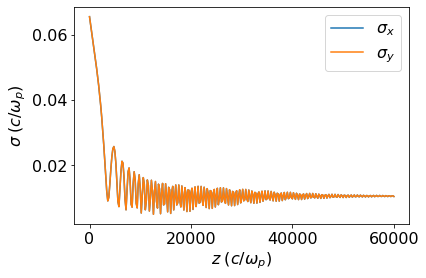

In [11]:
plot_sigma_m = False
plt.plot(parameters['s'], parameters['sigma_x'],label=r'$\sigma_x$')
plt.plot(parameters['s'], parameters['sigma_y'],label=r'$\sigma_y$')
if plot_sigma_m:
    s1 = 15000
    s2 = 60000
    idx1 = int(s1 / delta_s_matched)
    idx2 = int(s2 / delta_s_matched)
    s_plot = matched_parameters['s'][idx1:idx2+1]
    sigma_m_plot = matched_parameters['sigma_m'][idx1:idx2+1]
    plt.plot(s_plot,sigma_m_plot,'--',label=r'$\sigma_m$')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel(r'$\sigma \;(c/\omega_p)$')

plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
temp = '_with_sigma_m' if plot_sigma_m else ''
plt.savefig('beam'+str(beam_number)+'_sigma'+temp+'.png')
plt.show()

# $$\alpha$$

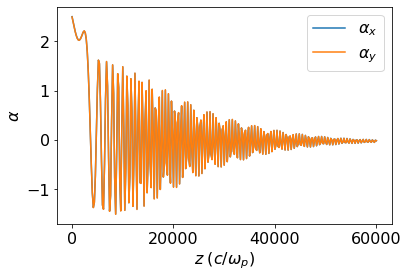

In [12]:
plot_alpha_m = False
plot_alpha_vacuum = False

plt.plot(parameters['s'], parameters['alpha_x'],label=r'$\alpha_x$')
plt.plot(parameters['s'], parameters['alpha_y'],label=r'$\alpha_y$')
if plot_alpha_m:
    s1 = 20000
    s2 = 60000
    idx1 = int(s1 / delta_s_matched)
    idx2 = int(s2 / delta_s_matched)
    s_plot = matched_parameters['s'][idx1:idx2+1]
    alpha_m_plot = matched_parameters['alpha_m'][idx1:idx2+1]
    plt.plot(s_plot,alpha_m_plot,'--',label=r'$\alpha_m$')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel(r'$\alpha$')


if plot_alpha_vacuum:
    s_cutoff = 10000 # only plot the vacuum evolution until s_cutoff
    idx = int(s_cutoff / delta_s)
    alpha_vacuum_plot = alpha_vacuum[:idx+1]
    s_plot = s[:idx+1]
    plt.plot(s_plot, alpha_vacuum_plot,'--',label='vacuum')

plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
temp = '_with_alpha_m' if plot_alpha_m else ''
plt.savefig('beam'+str(beam_number)+'_alpha'+temp+'.png')
plt.show()

# energy: $\gamma$

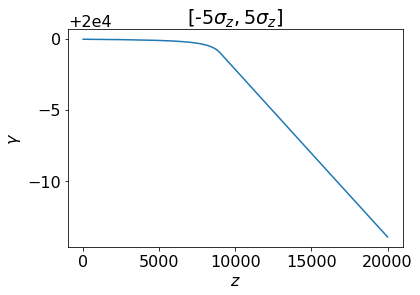

In [16]:
plt.plot(parameters['s'], parameters['energy'])
plt.xlabel('$z$')
plt.ylabel(r'$\gamma$')
# if half_thickness == 1:
#     plt.title(r'$[-\sigma_z,\sigma_z]$')
# else:
#     plt.title('[-'+str(half_thickness)+r'$\sigma_z,$'+str(half_thickness)+r'$\sigma_z]$')
plt.rcParams.update({'font.size': 16})
plt.savefig('beam'+str(beam_number)+'_energy'.png')
plt.show()

# energy spread: $\delta_\gamma / \gamma$

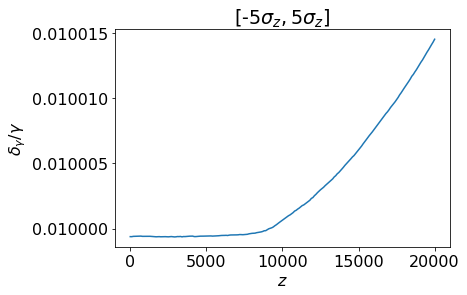

In [42]:
plt.plot(parameters['s'], parameters['energy_spread'])
plt.xlabel('$z$')
plt.ylabel(r'$\delta_\gamma / \gamma$')
# if half_thickness == 1:
#     plt.title(r'$[-\sigma_z,\sigma_z]$')
# else:
#     plt.title('[-'+str(half_thickness)+r'$\sigma_z,$'+str(half_thickness)+r'$\sigma_z]$')
plt.rcParams.update({'font.size': 16})
plt.savefig('beam'+str(beam_number)+'_energyspread_'+str(half_thickness)+'sigmaz'+'.png')
plt.show()

# $$d\gamma/dz$$

In [ ]:
# dgamma_dz_simulation = pyVisQP.NDiff1D(parameters['s'],parameters['energy'])

# # Check Mike litos's theory
# G0 = 1.18 # This parameter can be changed
# n_sqrt = np.sqrt(n)
# dgamma_dz_mike = G0 * n_sqrt * (2 * n_sqrt - 1)
# plt.plot(parameters['s'],dgamma_dz_simulation,label='QPAD')
# plt.plot(z,dgamma_dz_mike,label=r'$G_0\sqrt{\frac{n_p(z)}{n_{p0}}}(2\sqrt{\frac{n_p(z)}{n_{p0}}}-1)$')
# plt.xlabel('z')
# plt.ylabel(r'$\frac{d\gamma}{dz}$')
# plt.legend(loc='best')
# plt.rcParams.update({'font.size': 16})
# plt.savefig('beam'+str(beam_number)+'_dgamma_dz.png')
# plt.show()

### Plot the emittance evolution for multiple slices in witness beam

In [43]:
pyVisQP = reload(pyVisQP)

xi_s = [0.1,0.3,0.5,0.7,0.9]
half_thickness = 0.1

parameters_xi_s = [] 

for xi in xi_s:
    parameters_xi = pyVisQP.analyze_raw_beam_data(first_file_number = first_file_number,\
                                                  last_file_number = last_file_number,\
                                                  ndump = ndump,beam_number = beam_number, \
                                                  zVisualizeCenter = xi, half_thickness = half_thickness)
    parameters_xi_s.append(parameters_xi)
    
pyVisQP.save_beam_analysis(beam_number,xi_s,parameters_xi_s,half_thickness)

In file ../Beam1/Raw/raw_00000000.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000100.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000200.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000300.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000400.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000500.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000600.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000700.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000800.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00000900.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00001000.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00001100.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00001200.h5, analyzing 19.62% particles
In file ../Beam1/Raw/raw_00001300.h5, analyzing 19.61% particles
In file ../Beam1/Raw/raw_00001400.h5, analyzing 19.61% particles
In file ../Beam1/Raw/raw_

# $$\epsilon_n$$

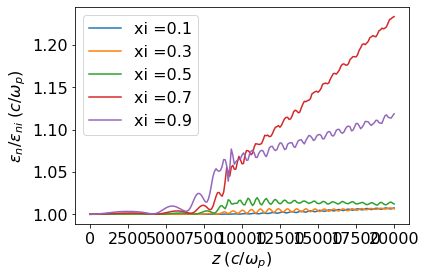

In [44]:
pyVisQP = reload(pyVisQP)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(xi_s)):
    plt.plot(parameters_xi_s[i]['s'], parameters_xi_s[i]['epsilon_n_x']/parameters_xi_s[i]['epsilon_n_x'][0],label='xi =' + str(xi_s[i]) )
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel('$\epsilon_n / \epsilon_{ni}  \;(c/\omega_p)$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 12})
fig.savefig('beam'+str(beam_number)+'_emitn_slices.png', format='png')
plt.show()

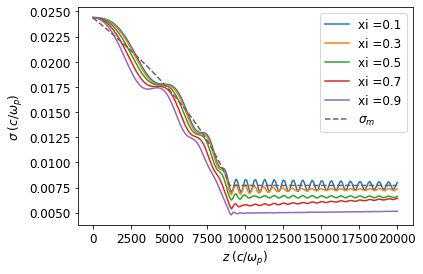

In [47]:
pyVisQP = reload(pyVisQP)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(xi_s)):
    plt.plot(parameters_xi_s[i]['s'], parameters_xi_s[i]['sigma_x'],label='xi =' + str(xi_s[i]) )
plt.plot(matched_parameters['s'],matched_parameters['sigma_m'],'--',label=r'$\sigma_m$')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel('$\sigma  \;(c/\omega_p)$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 12})
fig.savefig('beam'+str(beam_number)+'_sigma_slices.png', format='png')
plt.show()

## 1. Plasma and beam density
### angle = 0 (xz plane)

In [ ]:
angle = 0

# Plot the charge density of plasma and beam
filename1 = dirname +'/Species1/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname +'/Beam1/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filename3 = dirname +'/Beam2/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2,filename3]
scaleList = [1,1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = None)

### angle = 90 (yz plane)

In [ ]:
# Plot the y component of the focusing force : Fy with transverse and longitudinal lineout
filename1 = dirname + '/Fields/Er/Merged_angle_'+ str(angle) +'/er_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname + '/Fields/Bphi/Merged_angle_'+ str(angle) +'/bphi_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2]
scaleList = [-1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'transverse',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'longitudinal',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')

## 2. Accelerating field: $E_z$
### angle = 0 (xz plane)

In [ ]:
angle = 0
# Plot the accelerating field with transverse and longitudinal lineout
filename = dirname +'/Fields/Ez/Merged_angle_'+ str(angle) +'/ez_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename]
pyVisQP.makeplot(filenameList,LineoutDir = 'longitudinal',specify_title = '$E_z \; [mc\omega_p / e]$')
pyVisQP.makeplot(filenameList,LineoutDir = 'transverse',specify_title = '$E_z \; [mc\omega_p / e]$')

### angle = 90 (yz plane)

In [ ]:
angle = 90
# Plot the accelerating field with transverse and longitudinal lineout
filename = dirname +'/Fields/Ez/Merged_angle_'+ str(angle) +'/ez_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename]
pyVisQP.makeplot(filenameList,LineoutDir = 'longitudinal',specify_title = '$E_z \; [mc\omega_p / e]$')
pyVisQP.makeplot(filenameList,LineoutDir = 'transverse',specify_title = '$E_z \; [mc\omega_p / e]$')

## 3. Focusing force
### angle = 0 (xz plane)

In [ ]:
angle = 0

In [ ]:
# Plot the x component of the focusing force : Fx with transverse and longitudinal lineout
filename1 = dirname + '/Fields/Er/Merged_angle_'+ str(angle) +'/er_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname + '/Fields/Bphi/Merged_angle_'+ str(angle) +'/bphi_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2]
scaleList = [-1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'transverse',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'longitudinal',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')

### angle = 90 (yz plane)

In [ ]:
angle = 90

In [ ]:
# Plot the y component of the focusing force : Fy with transverse and longitudinal lineout
filename1 = dirname + '/Fields/Er/Merged_angle_'+ str(angle) +'/er_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname + '/Fields/Bphi/Merged_angle_'+ str(angle) +'/bphi_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2]
scaleList = [-1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'transverse',specify_title = '$F_y \; [mc\omega_p]$',Show_theory = 'focus')
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'longitudinal',specify_title = '$F_y \; [mc\omega_p]$',Show_theory = 'focus')

In [2]:
matched_parameters = get_matched_beam_parameters(i = 1,name = 'species',idx = 0,path = '..')

In [3]:
matched_parameters['sigma_m'][0]

0.018606501897257332